In [27]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import glob
from datetime import timedelta, date

# import tweepy
# import jsonpickle
import json
import re
import string
import nltk

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
#import en_core_web_sm
# import spacy
# from spacy import displacy
# from collections import Counter
# from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# import en_core_web_sm
# nlp = en_core_web_sm.load()
porter_stemmer = PorterStemmer()
rcParams['figure.figsize'] = 10,6

# I. Twitter Data

In [29]:
read_files = glob.glob("*.json")
tweets_data = []

for f in read_files:
    with open(f, "r") as infile:
        for line in infile:
            tweets_data.append(json.loads(line))
            

# with open("merged_file.json", "w") as outfile:
#     json.dump(tweets_data, outfile)

In [30]:
#create a new dataframe
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['created_at'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
tweets['screen_name'] = list(map(lambda tweet: tweet['screen_name'], tweets_data))
tweets.head()

,text,created_at,screen_name
0,Fox5DC: Boy hospitalized after early morning s...,2018-03-30 17:51:00,CrimeDC
1,Fox5DC: Police: Teen arrested for sexually ass...,2018-03-28 21:31:00,CrimeDC
2,Washington Post: Federal prosecutors dismiss a...,2018-03-23 19:34:00,CrimeDC
3,WUSA: 9 homicides in Ward 8 in March alone htt...,2018-03-23 18:21:00,CrimeDC
4,WJLA: Police: Man dead after shooting in South...,2018-03-22 15:51:00,CrimeDC


In [31]:
print('Total of tweets: ',tweets.shape[0])

tweets.drop_duplicates(inplace=True)
print('Total of tweets after dropping duplicates: ',tweets.shape[0])

Total of tweets:  8899
Total of tweets after dropping duplicates:  1327


## 1) EDA

In [32]:
#tweets['text'] = tweets['text'].str.split("http").str[0]
new=tweets['created_at'].str.split(" ",expand=True)
tweets['date']=new[0]
tweets['time']=new[1]
tweets['weekday']=tweets['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime('%a'))
tweets['hour']=tweets['time'].str.split(":").str[0]
# tweets['d']=tweets['date'].apply(lambda x: x.split("-")[0])
# tweets = tweets[tweets['d']=='2019']
# tweets.drop(['d'],axis=1,inplace=True)
tweets.head()

,text,created_at,screen_name,date,time,weekday,hour
0,Fox5DC: Boy hospitalized after early morning s...,2018-03-30 17:51:00,CrimeDC,2018-03-30,17:51:00,Fri,17
1,Fox5DC: Police: Teen arrested for sexually ass...,2018-03-28 21:31:00,CrimeDC,2018-03-28,21:31:00,Wed,21
2,Washington Post: Federal prosecutors dismiss a...,2018-03-23 19:34:00,CrimeDC,2018-03-23,19:34:00,Fri,19
3,WUSA: 9 homicides in Ward 8 in March alone htt...,2018-03-23 18:21:00,CrimeDC,2018-03-23,18:21:00,Fri,18
4,WJLA: Police: Man dead after shooting in South...,2018-03-22 15:51:00,CrimeDC,2018-03-22,15:51:00,Thu,15


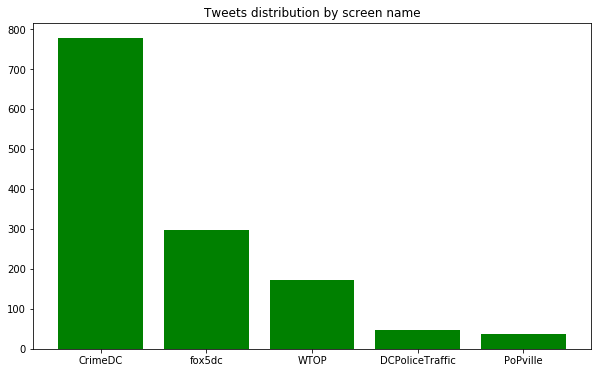

In [33]:
screen_name = pd.DataFrame(tweets.groupby('screen_name')['text'].count()).reset_index()
screen_name.sort_values(by='text',ascending=False, inplace=True)
plt.bar(screen_name['screen_name'],screen_name['text'],color='green')
plt.title('Tweets distribution by screen name')
plt.show()

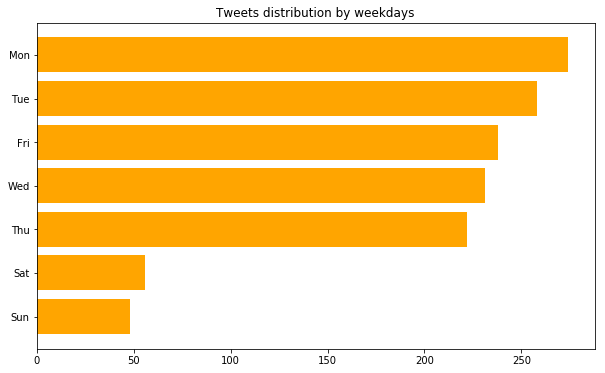

In [34]:
weekday = pd.DataFrame(tweets.groupby('weekday')['text'].count()).reset_index()
weekday = weekday.sort_values(by='text')
# plt.figure(figsize=(8,5))
plt.barh(weekday['weekday'],weekday['text'],color='orange')
plt.title('Tweets distribution by weekdays')
plt.show()


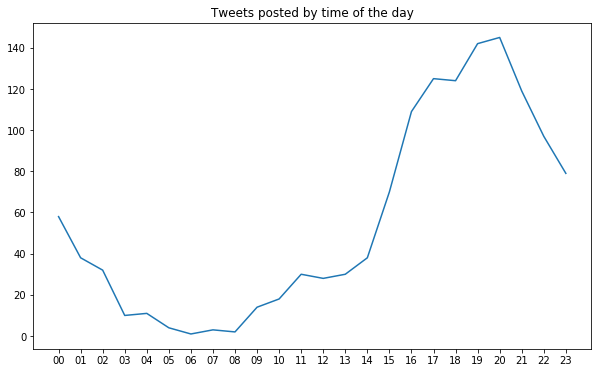

In [37]:
time = pd.DataFrame(tweets.groupby(['hour'])['text'].count())
plt.plot(time)
plt.title('Tweets posted by time of the day')
plt.show()

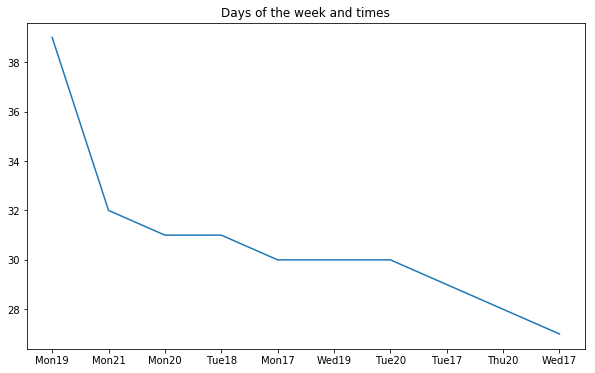

In [38]:
tweets['daytime'] = tweets['weekday']+tweets['hour']

daytime = pd.DataFrame(tweets.groupby(['daytime'])['text'].count())
daytime.sort_values(by='text',ascending=False,inplace=True)
plt.plot(daytime[:10])
plt.title('Days of the week and times')
plt.show()

tweets.drop(['weekday','daytime'],axis=1,inplace=True)

## 2) Text-preprocessing

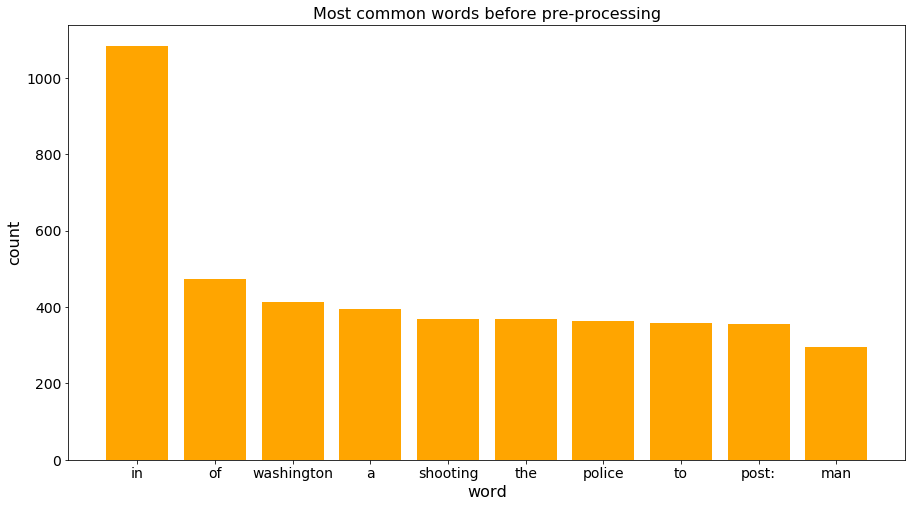

In [44]:
#the most common words
all_words = []
for line in list(tweets['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
labels, values = zip(*Counter(all_words).most_common(10))
indexes = np.arange(len(labels))
plt.figure(figsize=(15,8))
plt.bar(indexes, values,color='orange')
plt.xticks(indexes , labels,fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('count',fontsize=16)
plt.xlabel('word',fontsize=16)
plt.title('Most common words before pre-processing',fontsize=16)
plt.show()

In [45]:
def cleanText(tweet):
    #remove links
    tweet = re.sub(r'https?://[A-Za-z0-9./]+',' ',tweet)
    #remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    #remove @username
    tweet = re.sub(r'@[A-Za-z0-9]+','',tweet)
    #remove Punctuation   
    tweet = re.sub(r'[^\w\s]',' ',tweet)
     #remove words like 1st, 2nd
    tweet = re.sub(r'\d+[st|nd|rd|th]?','',tweet)
    #remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    #remove number
    tweet = re.sub(r'\d+', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # To lowercase
    tweet = tweet.lower()
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
        # Remove whitespace (including new line characters)
    tweet = re.sub(r'\foxdc', ' ', tweet)
    tweet = re.sub(r'\washington post', ' ', tweet)
    tweet = re.sub(r'\wusa', ' ', tweet)
    tweet = re.sub(r'\wjla', ' ', tweet)
    return tweet

# apply to text column
tweets['cleaned'] = tweets['text'].apply(cleanText)
tweets['cleaned'].head()

0    foxdc boy hospitalized after early morning sho...
1    foxdc police teen arrested for sexually assaul...
2      federal prosecutors dismiss assault charges ...
3                          homicides ward march alone 
4            police man dead after shooting southeast 
Name: cleaned, dtype: object

In [46]:
#remove stop words
stop_words = stopwords.words('english')
# tokenize helper function
def processText(tweet):

    sent = nltk.word_tokenize(tweet)
#     tagged_sentence = nltk.tag.pos_tag(sent)
    #print(tagged_sentence)
#     edited_sentence = [word for word,tag in tagged_sentence if tag != 'NN' and tag != 'NNS']
    #print(edited_sentence)
    #remove any stopwords
    nostopword = [word for word in sent if word not in stopwords.words('english')]
    #stemming
    stemmed_words = [porter_stemmer.stem(word) for word in nostopword]
#     lemmatized_token = [wordnet_lemmatizer.lemmatize(word) for word in stemmed_words]
    return stemmed_words

# apply to column
tweets['tokens'] = tweets['cleaned'].apply(processText)
tweets.head()

,text,created_at,screen_name,date,time,hour,cleaned,tokens,tokenafter
0,Fox5DC: Boy hospitalized after early morning s...,2018-03-30 17:51:00,CrimeDC,2018-03-30,17:51:00,17,foxdc boy hospitalized after early morning sho...,"[foxdc, boy, hospit, earli, morn, shoot, north...",foxdc boy hospit earli morn shoot northwest
1,Fox5DC: Police: Teen arrested for sexually ass...,2018-03-28 21:31:00,CrimeDC,2018-03-28,21:31:00,21,foxdc police teen arrested for sexually assaul...,"[foxdc, polic, teen, arrest, sexual, assault, ...",foxdc polic teen arrest sexual assault woman f...
2,Washington Post: Federal prosecutors dismiss a...,2018-03-23 19:34:00,CrimeDC,2018-03-23,19:34:00,19,federal prosecutors dismiss assault charges ...,"[feder, prosecutor, dismiss, assault, charg, t...",feder prosecutor dismiss assault charg turkish...
3,WUSA: 9 homicides in Ward 8 in March alone htt...,2018-03-23 18:21:00,CrimeDC,2018-03-23,18:21:00,18,homicides ward march alone,"[homicid, ward, march, alon]",homicid ward march alon
4,WJLA: Police: Man dead after shooting in South...,2018-03-22 15:51:00,CrimeDC,2018-03-22,15:51:00,15,police man dead after shooting southeast,"[polic, man, dead, shoot, southeast]",polic man dead shoot southeast


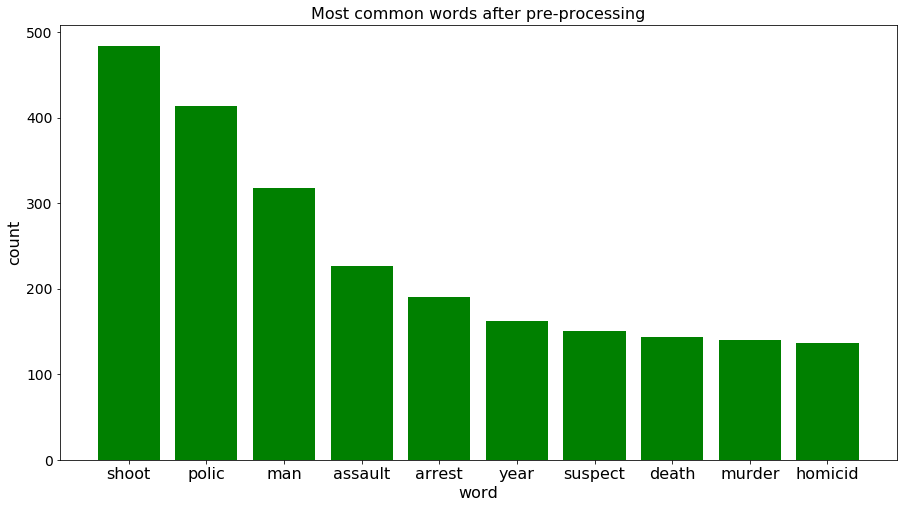

In [47]:
# most common words after clean up and remove stop words
all_words = []
for ls in tweets['tokens']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())

labels, values = zip(*Counter(all_words).most_common(10))
indexes = np.arange(len(labels))
plt.figure(figsize=(15,8))
plt.bar(indexes, values,color='green')
plt.xticks(indexes , labels,fontsize=16)
plt.yticks(fontsize=14)
plt.title('Most common words after pre-processing',fontsize=16)
plt.ylabel('count',fontsize=16)
plt.xlabel('word',fontsize=16)
plt.show()

In [48]:
for i in tweets['tokens']:
    temp = ' '.join(i)
    tweets['tokenafter']=temp
tweets['tokenafter'] = [' '.join(map(str, l)) for l in tweets['tokens']]

## 3) N-grams & Topic Modeling

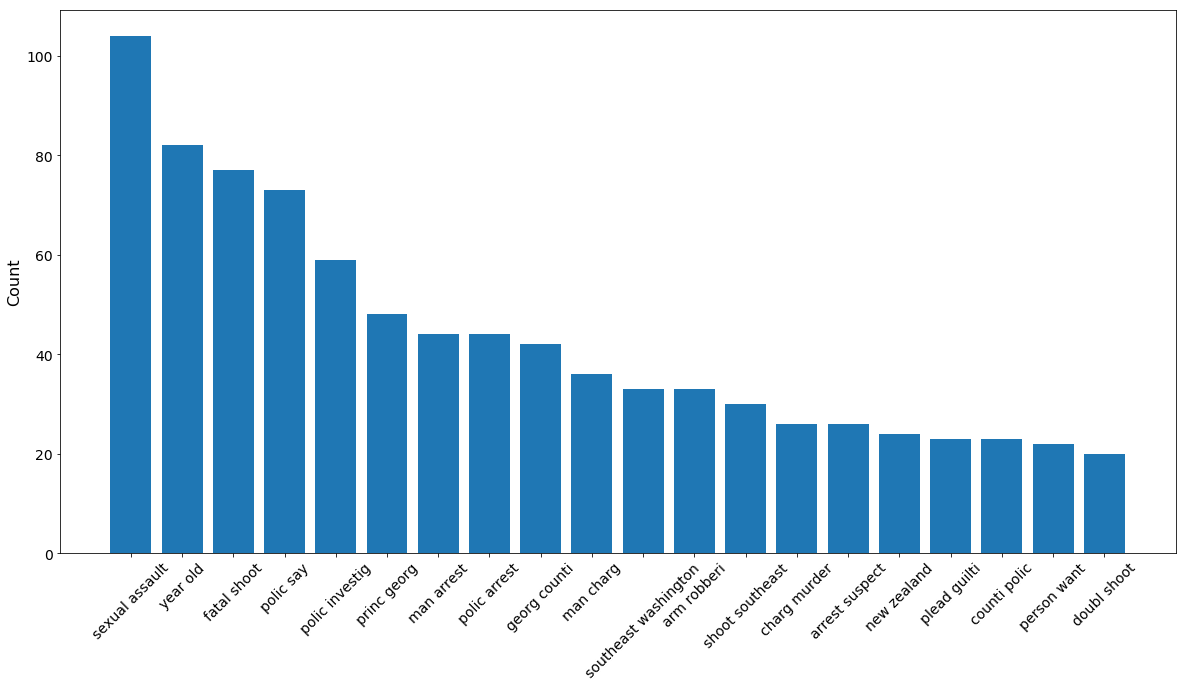

In [49]:
#bi-grams
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(tweets['tokenafter'], 20)

df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
plt.figure(figsize=(20,10))
plt.bar(df1['Text'],df1['count'])
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Count',fontsize=16)
plt.show()


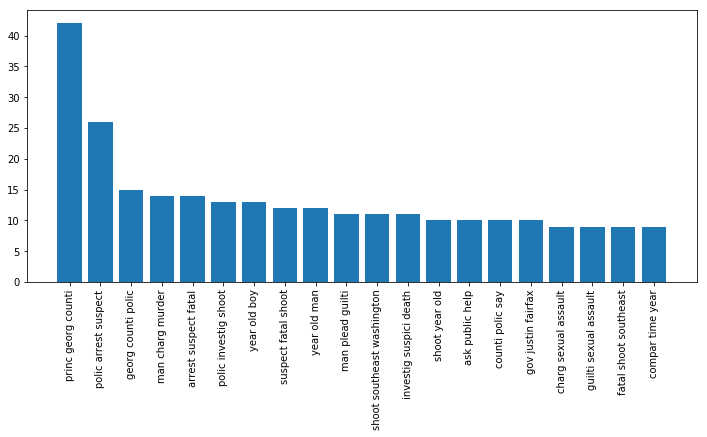

In [50]:
#tri-grams
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(tweets['tokenafter'], 20)

df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
plt.figure(figsize=(12,5))
plt.bar(df2['Text'],df2['count'])
plt.xticks(rotation=90)
plt.show()

In [51]:
reindexed_data = tweets['tokenafter']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 4
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)


def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    print(count_pairs)
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(",".join(topic_words))         
    return top_words
    
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])


dict_items([(0, 865), (2, 212), (3, 95), (1, 155)])
Topic 1:  shoot,man,polic
Topic 2:  want,robberi,person
Topic 3:  assault,sexual,murder
Topic 4:  homicid,investig,year


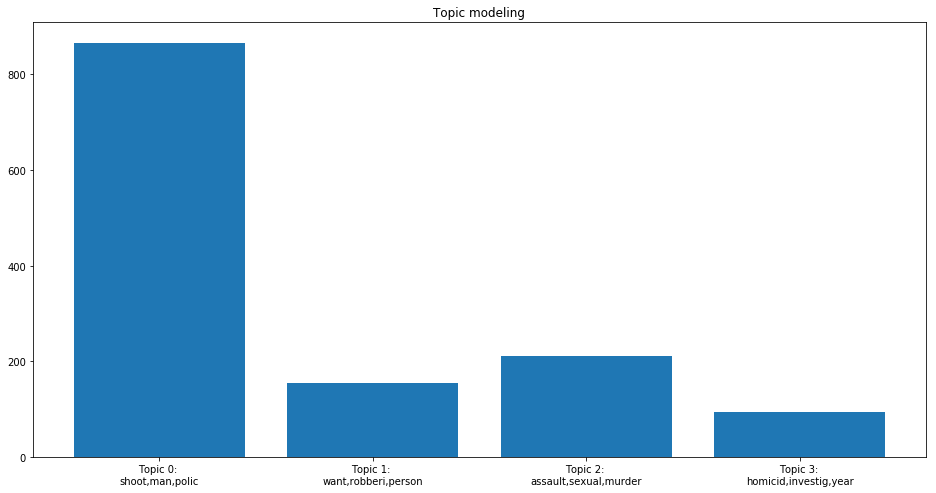

In [52]:
labels = ['Topic {}: \n'.format(i) + top_n_words_lsa[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
# ax.set_ylabel('Number of review text');
ax.set_title('Topic modeling');
plt.show();

## 4) Classification

In [53]:
tweets['type']=np.NaN
shooting = ['shoot','arm','shot']
assault = ['assault','stab']
buglar = ['burglar','burglari']
crash = ['crash','drive','accident','car','accid']
homicide = ['murder','homicide','homicid']
theft = ['theft','steal']
robbery = ['robberi', 'robber']
sexualassault = ['sexual','sex'] 
for idx, row in tweets.iterrows():
    for word in tweets.loc[idx,'tokens']:
        if word in sexualassault:
            tweets.loc[idx,'type'] = 'sex abuse'
            break
        elif word in buglar:
            tweets.loc[idx,'type'] = 'burglary'
            break
        elif word in assault:
            tweets.loc[idx,'type'] = 'assault'
            break
        elif word in crash:
            tweets.loc[idx,'type'] = 'crash'
            break
        elif word in homicide:
            tweets.loc[idx,'type'] = 'homicide'
            break
        elif word in theft:
            tweets.loc[idx,'type'] = 'theft'
            break
#         elif word in murder:
#             tweets.loc[idx,'type'] = 'murder'
            break
        elif word in robbery:
            tweets.loc[idx,'type'] = 'robbery'
            break
        elif word in shooting:
            tweets.loc[idx,'type'] = 'shooting'
                        
            

In [55]:
print('Total tweets: ',tweets.shape[0])
print('Unable to classify: ',tweets['type'].isnull().sum()) 

Total tweets:  1327
Unable to classify:  102


********************************************************************

# II. Police Report

In [56]:
policerep = pd.read_csv('C:/Users/tinan/Desktop/NLP/tweets0423/tweets/dc-crime.csv')

police = pd.DataFrame()
police =policerep[['location','START_DATE','OFFENSE']].copy()
police['date'] = pd.to_datetime(police['START_DATE']).dt.date #extract the dates 
police['hour'] = police['START_DATE'].apply(lambda x: x[11:13]) #extract the hours 
police['date']=police['date'].apply(lambda x: str(x))
police = police.replace('assault w/dangerous weapon','assault')
police['OFFENSE']=police['OFFENSE'].replace('motor vehicle theft','theft')
police['OFFENSE']=police['OFFENSE'].replace('theft f/auto','theft')
police['OFFENSE']=police['OFFENSE'].replace('theft/other','theft')
police.head()

,location,START_DATE,OFFENSE,date,hour
0,"38.936972708940239,-77.024408596883461",2019-04-03T23:12:24.000,robbery,2019-04-03,23
1,"38.905649312452539,-77.030565950322227",2019-04-03T23:00:45.000,theft,2019-04-03,23
2,"38.904382904578725,-76.992681430060301",2019-04-03T23:00:06.000,theft,2019-04-03,23
3,"38.92015633637488,-76.990315863805236",2019-04-03T22:54:16.000,theft,2019-04-03,22
4,"38.906455435552409,-77.044897140495749",2019-04-03T22:50:10.000,sex abuse,2019-04-03,22


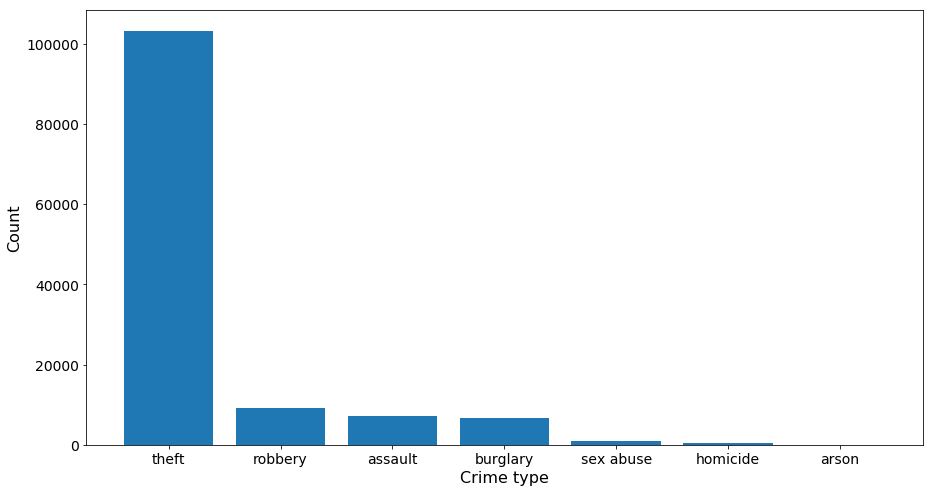

In [57]:
pgroup = pd.DataFrame(police.groupby(['OFFENSE'])['hour'].count()).reset_index().sort_values('hour',ascending=False)
plt.figure(figsize=(15,8))
plt.bar(pgroup.OFFENSE,pgroup.hour)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Crime type',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.show()

# III. Evaluation

## a. Matching by date

In [58]:
#count how many times a type of crime happen on a given date - Twitter data
#ONLY USE 2019 DATA
tweets['timereported'] = pd.to_datetime(tweets['date']).dt.date
# tweets['timereported'] = pd.to_datetime(tweets['created_at'])
group1 = tweets.groupby(['timereported','type'])['type'].count()
def reshape(group):
    df = pd.DataFrame(group).unstack().reset_index().fillna(0)
    df.columns = df.columns.droplevel()
    df = df.rename(columns={'':'datereported'})
    df['datereported'] = pd.to_datetime(df['datereported'])

    #look at data in 2019

#     for idx, row in tweets.iterrows():
#         df = df[df['datereported'].dt.year == 2019]
    return df

tweetdata = reshape(group1)
tweetdata.head(3)

type,datereported,assault,burglary,crash,homicide,robbery,sex abuse,shooting,theft
0,2015-08-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2015-08-06,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2015-08-07,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
#count how many time a type of crime reported on a given date - Police data
#ONLY USE 2019 DATA
group2 = police.groupby(['date','OFFENSE'])['OFFENSE'].count()
policedata = reshape(group2)

In [60]:
#summary of how many crimes reported in both datasets. (might need to filter out the dates so both of them are in the same time frame)

results = pd.DataFrame({'':['PoliceData','TwitterData'],'assault':[policedata.assault.sum(),tweetdata.assault.sum()],'burglary':
                       [policedata.burglary.sum(),tweetdata.burglary.sum()],'homicide':[policedata.homicide.sum(),tweetdata.homicide.sum()],
                       'robbery':[policedata.robbery.sum(),tweetdata.robbery.sum()],'sexabuse':[policedata['sex abuse'].sum(),tweetdata['sex abuse'].sum()],
                       'theft':[policedata.theft.sum(),tweetdata.theft.sum()],'crash':[0,tweetdata.crash.sum()],'shooting':[0,tweetdata.shooting.sum()]})
results.head()


,,assault,burglary,homicide,robbery,sexabuse,theft,crash,shooting
0,PoliceData,7138.0,6560.0,513.0,9070.0,1067.0,103215.0,0.0,0.0
1,TwitterData,128.0,28.0,259.0,112.0,133.0,24.0,105.0,436.0


In [61]:
results.sum(axis=1)

0    127563.0
1      1225.0
dtype: float64

<h3> b/ Matching by time

In [62]:
#create a range of time when the tweet is posted....+/- 1 hours. If tweet is posted at 3am, the range would be (2,4).
tweets['rangetime']=tweets['hour'].apply(lambda x: [int(x)-1,int(x)+1])

tweets.sort_values('date',inplace=True)
tweets.reset_index(inplace=True)
tweets['id']= tweets.index 
tweets.drop(['created_at','text','screen_name','time','tokens','cleaned','index'],axis=1,inplace=True)
tweets['id']=tweets['id'].apply(lambda x:"ID"+"-"+str(x)) #assign a unique id for each tweet
tweets.tail()

,date,hour,tokenafter,type,timereported,rangetime,id
1322,2019-04-02,23,man charg murder assault year old syndrom inte...,homicide,2019-04-02,"[22, 24]",ID-1322
1323,2019-04-02,02,sex assault alleg magician david blain investi...,sex abuse,2019-04-02,"[1, 3]",ID-1323
1324,2019-04-03,12,interview former gang member yesterday serv se...,homicide,2019-04-03,"[11, 13]",ID-1324
1325,2019-04-03,00,cash reward offer inform murder ashanti carmon...,homicide,2019-04-03,"[-1, 1]",ID-1325
1326,2019-04-03,02,polic say arrest man suspect fatal shoot rappe...,shooting,2019-04-03,"[1, 3]",ID-1326


In [63]:
df_=pd.DataFrame()
index=[]
index1=[]
newday=[]
typetweet=[]
typepol=[]
phours=[]
thours=[]
trange=[]
idno=[]
for row in tweets.itertuples():
    for row1 in police.itertuples():
        #if the date in both datasets match and the hour reported in police db is within the range of tweet, and the crime
        #type match then output all these columns to a new dataframe
        if (row1.date==row.date) and (int(row1.hour) >= int(row.rangetime[0])) and (int(row1.hour) <= int(row.rangetime[1])) and (row1.OFFENSE==row.type):
            idno.append(row.id)
            newday.append(row.date)
            typetweet.append(row.type)
            typepol.append(row1.OFFENSE)
            phours.append(row1.hour)
            thours.append(row.hour)
            trange.append(row.rangetime)
            df_ = pd.DataFrame(list(zip(idno,newday,typetweet,typepol,phours,trange,thours)),columns=['ID','timereported','tw_type',
                                                                                                'po_type','pl_hr','range','tw_hr'])
          
        else:
            continue

In [65]:
#interpret the table: for the tweet ID-101, there is one match with police db
#ID-1039, there are 2 possible matches since the time reported for these 2 events fall within the time the tweet is posted. We count this as one match
hr = pd.DataFrame(df_.groupby(['ID','tw_type'])['tw_hr'].count()).reset_index()
hr.columns = ['ID','type','matched']
print("Numbers of tweet that matched:") 
print(hr.shape[0])
hr.head(10)

Numbers of tweet that matched:
195


,ID,type,matched
0,ID-101,robbery,1
1,ID-1039,robbery,2
2,ID-1042,theft,15
3,ID-1054,sex abuse,1
4,ID-1065,homicide,1
5,ID-1073,robbery,1
6,ID-109,robbery,2
7,ID-1096,theft,5
8,ID-1097,theft,12
9,ID-110,robbery,1


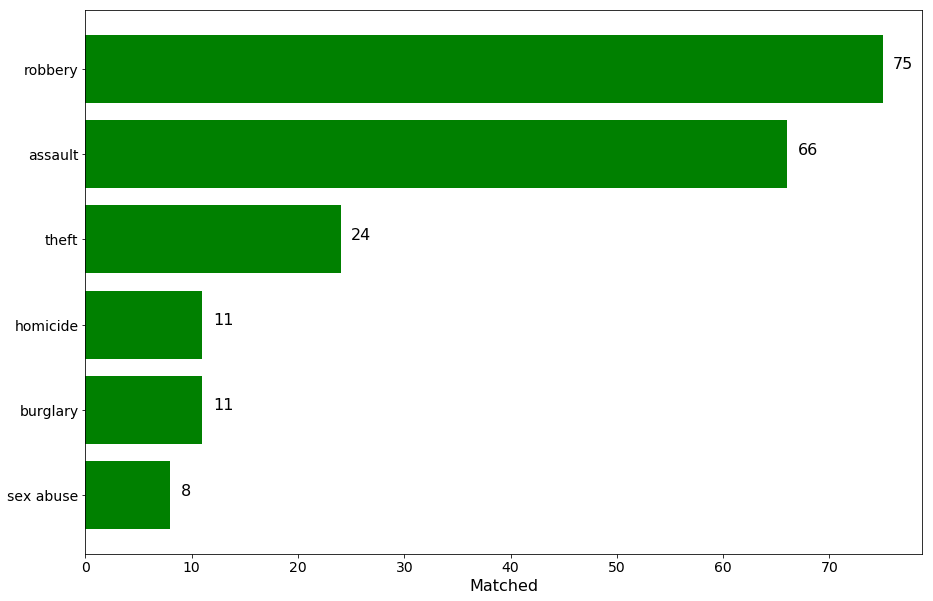

In [66]:
#matched tweets distribution
hrg = pd.DataFrame(hr.groupby('type')['matched'].count()).sort_values('matched').reset_index()

fig, ax = plt.subplots(figsize=(15,10))
ax.barh(hrg['type'], hrg['matched'], 
        color='green', ecolor='black')
ax.set_xlabel('Matched',fontsize=16)
for i, v in enumerate(hrg['matched']):
    ax.text(v + 1, i, str(v), color='black',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()
# plt.savefig('matched.png')